In [7]:
import glob
from PIL import Image
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Homework 2, part 1

## transfer learning
1. below you will find the dataset object for the galaxy dataset from homework 1, except that now it outputs a 69x69 image (no flattening), and the single grayscale channel is repeated 3 times to give a 3x69x69 image

2. load a pre-trained network from pytorchs selection https://pytorch.org/docs/stable/torchvision/models.html

3. create a network to classify the galaxy image dataset with some parts from the pretrained network

4. train the new network

5. when you reach over 75% accuracy on the validation dataset, submit your trained model (state_dict and source code)

6. double check that if you train the same model without the pre-trained weights, it will perform worse (no need to submit this model) 

In [1]:
path_to_training_data = '../Dataset/train/'
path_to_validation_data = '../Dataset/validation/'

In [2]:
import glob
from PIL import Image
from PIL import ImageFilter
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


class CustomDataset(Dataset):
    def __init__(self, path,mean=0.092,std=0.127,n_classes=10,transform=False):
        
        self.mean = mean
        self.std = std
        
        self.do_transform = transform
        self.transform = transforms.RandomRotation(180)
        
        self.filelist = glob.glob(path+'/*.png')
        
        self.labels = np.zeros(len(self.filelist))
        
        for class_i in range(n_classes):
            self.labels[ np.array(['class'+str(class_i) in x for x in self.filelist]) ] = class_i
        self.labels = torch.LongTensor(self.labels)
        
        
    def __len__(self):
       
        return len(self.filelist)

    def __getitem__(self, idx):
        
        img = Image.open(self.filelist[idx])
    
        if self.do_transform:
            
            img = self.transform(img)
        
        
        x = transforms.ToTensor()(img)
        
        x = (x-self.mean)/self.std
        
        x = x.repeat(3,1,1)
        
        
        class_label = self.labels[idx]
        
        return x, class_label

In [3]:
train_ds = CustomDataset(path_to_training_data,transform=False)
valid_ds = CustomDataset(path_to_validation_data,transform=False)

In [4]:
x,y = train_ds[553]

In [5]:
x.shape

torch.Size([3, 69, 69])

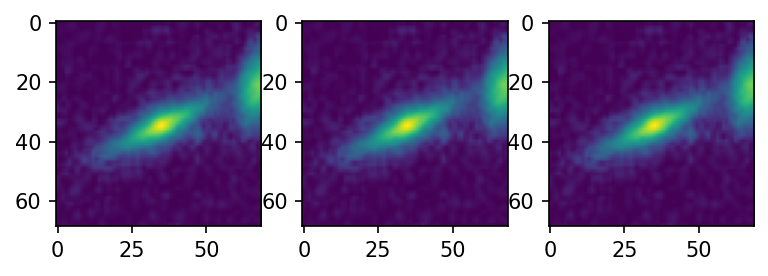

In [8]:
fig,ax = plt.subplots(1,3,figsize=(6,2),dpi=150)

for i in range(3):
    ax[i].imshow(x[i])

In [11]:
import torchvision.models as models


vgg11 = models.vgg16(pretrained=True)
#vgg11 = models.vgg11(pretrained=False)

In [12]:
vgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
??vgg11

In [ ]:
class ImageClassifier(nn.Module):

    def __init__(self):
        super(ImageClassifier, self).__init__()
        
        #you can take all of the conv layers before the max pooling,
        self.features = vgg11.features
        
        #or you can take a subset of them
        self.conv1 = vgg11.features[0]
        self.conv2 = vgg11.features[3]
        self.conv3 = vgg11.features[6]
        
        #if you want to use subsets of a sequential model:
        self.part1 = nn.Sequential(*[vgg11.features[i] for i in range(16)])
        
        self.classifier = #...
        
    def forward(self, x):
        out = self.features(x)
        
        ##### pass through the rest of your model
        
        return out

In [ ]:
img_class = ImageClassifier()

In [ ]:
training_ds = CustomDataset(path_to_training_data,transform=False)
validation_ds = CustomDataset(path_to_validation_data)

tranining_tensor = torch.stack([training_ds[i][0] for i in range(len(training_ds)) ])
training_labels = training_ds.labels.data.numpy()

validation_tensor = torch.stack([validation_ds[i][0] for i in range(len(validation_ds)) ])
validation_labels = validation_ds.labels.data.numpy()

In [ ]:
def dataset_accuracy(tensor_dataset,targets,net):
    
    net.eval()
    
    net.cpu()
    
    output = net(tensor_dataset)
    
    loss = nn.CrossEntropyLoss()(output,torch.LongTensor(targets)) 

    output = output.data.numpy()
    prediction = np.argmax(output,axis=1)

    n_correct = len(np.where(targets==prediction)[0])
    n_total = len(targets)
    
    if torch.cuda.is_available():
        net.cuda()
    return n_correct/n_total, loss.item()

In [ ]:
dataset_accuracy(validation_tensor,validation_labels, img_class, nn.CrossEntropyLoss())